# Home Credit Default Risk - Team 3 (Kahsai, Nichols, Pellerito)
Objective: build a model that identifies consumer loan customers who are most likely to default on their loan obligations. We will consider model types: logistic regression, decision tree, random forest, extra trees, XG Boost and Light Gradient Boost Machine. (And maybe some ensemble models at the end.) This notebook imports the file train1205.pkl, produced by the Data Generation Notebook.

### Import packages

In [13]:
# standard Python tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# special tools for working in Kaggle
import joblib   # save and load ML models
import gc       # garbage collection
import os 
import sklearn
import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# preprocessing steps
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# machine learning models and tools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from sklearn.svm import SVR
from sklearn import datasets

# Optuna
import optuna as op
from optuna import create_study

# cross validation and metrics - remember this competition is scored as area under curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

# clear out any old junk
gc.collect()

# Let's put this someplace where it's easy to find - the proportion split between training and validation data
train_size = 0.75

# Import the training data (already processed and merged)

### Read the training data

In [14]:
# Main table
pd.options.display.max_columns = None
train = pd.read_pickle('../input/testandtrain1205/train1205.pkl')
train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CI_ratio,AI_ratio,AC_ratio,CG_ratio,log_INCOME,log_ANNUITY,log_CREDIT,log_GOODS,FLAG_CG_ratio,DAYS_ID_4200,AVG_EXT,EXT_SOURCE_MAX,EXT_SOURCE_MIN,BU_CREDIT_ACTIVE_Active,BU_CREDIT_ACTIVE_Bad debt,BU_CREDIT_ACTIVE_Closed,BU_CREDIT_ACTIVE_Sold,BU_CREDIT_CURRENCY_currency 1,BU_CREDIT_CURRENCY_currency 2,BU_CREDIT_CURRENCY_currency 3,BU_CREDIT_CURRENCY_currency 4,BU_CREDIT_TYPE_Another type of loan,BU_CREDIT_TYPE_Car loan,BU_CREDIT_TYPE_Cash loan (non-earmarked),BU_CREDIT_TYPE_Consumer credit,BU_CREDIT_TYPE_Credit card,BU_CREDIT_TYPE_Loan for business development,BU_CREDIT_TYPE_Loan for purchase of shares (margin lending),BU_CREDIT_TYPE_Loan for the purchase of equipment,BU_CREDIT_TYPE_Loan for working capital replenishment,BU_CREDIT_TYPE_Microloan,BU_CREDIT_TYPE_Mobile operator loan,BU_CREDIT_TYPE_Mortgage,BU_CREDIT_TYPE_Real estate loan,BU_CREDIT_TYPE_Unknown type of loan,BU_CREDIT_ACTIVE,BU_DAYS_CREDIT,BU_CREDIT_DAY_OVERDUE,BU_DAYS_CREDIT_ENDDATE,BU_DAYS_ENDDATE_FACT,BU_AMT_CREDIT_MAX_OVERDUE,BU_CNT_CREDIT_PROLONG,BU_AMT_CREDIT_SUM,BU_AMT_CREDIT_SUM_DEBT,BU_AMT_CREDIT_SUM_LIMIT,BU_AMT_CREDIT_SUM_OVERDUE,BU_DAYS_CREDIT_UPDATE,BU_AMT_ANNUITY,BU_BB_0,BU_BB_1,BU_BB_2,BU_BB_3,BU_BB_4,BU_BB_5,BU_BB_C,BU_BB_X,BU_BB_All,BU_BB12_0,BU_BB12_1,BU_BB12_2,BU_BB12_3,BU_BB12_4,BU_BB12_5,BU_BB12_C,BU_BB12_X,BU_BB12_All,OD_ratio,Credit_ratio,Debt_ratio,REMAIN_CRED,AC_RATIO,CC_NAME_CONTRACT_STATUS_Active,CC_NAME_CONTRACT_STATUS_Approved,CC_NAME_CONTRACT_STATUS_Completed,CC_NAME_CONTRACT_STATUS_Demand,CC_NAME_CONTRACT_STATUS_Refused,CC_NAME_CONTRACT_STATUS_Sent proposal,CC_NAME_CONTRACT_STATUS_Signed,CC_MONTHS_BALANCE,CC_AMT_BALANCE,CC_AMT_CREDIT_LIMIT_ACTUAL,CC_AMT_DRAWINGS_ATM_CURRENT,CC_AMT_DRAWINGS_CURRENT,CC_AMT_DRAWINGS_OTHER_CURRENT,CC_AMT_DRAWINGS_POS_CURRENT,CC_AMT_INST_MIN_REGULARITY,CC_AMT_PAYMEN

### Split the training and validation sets
For some early model runs, we used as little as 10% of the training data. By the end, we were using 75% for training and holding back 25% for validation. The parameter that controls the proportion of the train/test split is called test_size and can be found in the first code cell of this notebook.

In [15]:
y = train['TARGET'].values
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(['TARGET', 'SK_ID_CURR'], axis = 1), y, stratify = y, test_size=1 - train_size, random_state=1)
print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_valid:',X_valid.shape)
print('Shape of y_valid:',y_valid.shape)

Shape of X_train: (230633, 413)
Shape of y_train: (230633,)
Shape of X_valid: (76878, 413)
Shape of y_valid: (76878,)


### make lists of cat and num features for pipeline, based on dtype
we need to identify which factors are categorical and which are numeric, so that the pipeline knows how to process them.

In [16]:
types = np.array([z for z in X_train.dtypes])        # array([dtype('float64'), dtype('float64'), dtype('O'), dtype('O') ...])
all_columns = X_train.columns.values                 # list of all column names
is_num = types != 'object'                           # returns array([False, False, False, False,  True,  True, ...) where True is a numeric variable
num_features = all_columns[is_num].tolist()          # list of all numeric columns
cat_features = all_columns[~is_num].tolist()         # list of all categorical columns

print(len(num_features), "numeric features")
print(len(cat_features), "categorical features")

398 numeric features
15 categorical features


### build model pipeline based on num_cols and cat_cols lists

In [17]:
features = num_features + cat_features

Pipe_num = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'median')),        # tried median, mean, constant strategies
    ('scaler', StandardScaler())       ])

Pipe_cat = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder())        ])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipe_num, num_features),
        ('cat', Pipe_cat, cat_features)])

preprocessor.fit(train[features])
X_train = preprocessor.transform(X_train[features])
X_valid = preprocessor.transform(X_valid[features])

print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)

gc.collect()

del train            # yes, it is safe to delete this - from now on we are only working with X_train, X_valid, y_train, y_valid
gc.collect()

Shape of X_train: (230633, 486)
Shape of y_train: (230633,)


0

### Build Model Scoreboard
Each time we run a new model, we will append a new row to the scoreboard.

In [18]:
pd.set_option('display.max_colwidth', None)             # LGBM in particular has long hyperparameters and I want to see them all
results = pd.DataFrame(columns = ['Model Type','AUC - 10xv', 'AUC - Valid', 'Hyperparameters'])

### Memory Management
The only data frame open right now should be the model scoreboard 'results' that we just created. Even the train dataframe can be closed now because the information it contained is stored in arrays X_train, X_valid, etc. We should have about 15 GB free at this point.

In [19]:
%who_ls DataFrame

['results']

In [20]:
import psutil
print(psutil.virtual_memory()[1]/2**30, "GB free")

12.508289337158203 GB free


# Models

### Logistic Regression
I tried both lbfgs and saga solvers, and got faster performance (and slightly higher scoring) out of lbfgs. I experimented with max_iter as low as 200, but did not see any degradation of accuracy below 400. L2 (ridge regression) regularization parameter easily outperformed L1. This model didn't outperform LightGBM or XGBoost, but it might be a candidate for an ensemble model.

In [21]:
%%time
warnings.filterwarnings("ignore", category = ConvergenceWarning)    # seems like we are okay if we set the max_iter threshold around 400.

lr_clf = LogisticRegression(max_iter = 400, solver = 'lbfgs')       # lbfgs is running rings around saga

lr_parameters = {"C" : [0.005], "penalty" : ['l2']}
lr_grid = GridSearchCV(lr_clf, lr_parameters, cv=10, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

lr_model = lr_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Logistic Regression',
                          'AUC - 10xv' : lr_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, lr_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : lr_grid.best_params_},
                        ignore_index=True)
results

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.9min finished


CPU times: user 1min 43s, sys: 19 s, total: 2min 2s
Wall time: 3min 23s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.763948,0.768523,"{'C': 0.005, 'penalty': 'l2'}"


### Decision Tree
The best parameters I could find for the decision tree were max_depth = 8 and min_samples_leaf = 10. This model is not going to be our best, but it provides a benchmark that our Random Forest and Extra Trees models should be able to beat. (Both those models are based on collections of decision trees.)

In [22]:
%%time
dt_clf = DecisionTreeClassifier(random_state=1)
dt_parameters = {'max_depth': [8], 'min_samples_leaf': [10]}

dt_grid = GridSearchCV(dt_clf, dt_parameters, cv=10, refit='True', n_jobs=-1, verbose=0, scoring='roc_auc')
dt_grid.fit(X_train, y_train)
dt_model = dt_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Decision Tree',
                          'AUC - 10xv' : dt_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, dt_model.predict_proba(X_valid)[:,1]),
                          'Hyperparameters' : dt_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

CPU times: user 32 s, sys: 731 ms, total: 32.7 s
Wall time: 2min 39s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.763948,0.768523,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.722701,0.730909,"{'max_depth': 8, 'min_samples_leaf': 10}"


### Random Forest
We are going to use Optuna to tune the hyperparameters (max_depth and min_samples_leaf) for the random forest model, and then run the full model based on the Optuna results. (See appendix for results.) I used 39 and 37 as my final hyperparameters, but the model doesn't seem to be very sensitive over a pretty wide range of choices. Basically any pair of numbers in the 30-40 range is giving us about the same results.

In [23]:
%%time
rf_clf = RandomForestClassifier(random_state=1, n_estimators=100)
rf_parameters = {'max_depth': [39],  'min_samples_leaf': [37]}        # results from Optuna study
rf_grid = GridSearchCV(rf_clf, rf_parameters, cv=10, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Random Forest',
                          'AUC - 10xv' : rf_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, rf_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : rf_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.7min finished


CPU times: user 3min 3s, sys: 693 ms, total: 3min 4s
Wall time: 15min 43s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.763948,0.768523,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.722701,0.730909,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.758414,0.764844,"{'max_depth': 39, 'min_samples_leaf': 37}"


### Extra Trees
Now with more trees! Similar to Random Forest in that it uses a collection of Decision Trees to make a classification. Main difference is that Extra Trees model uses the whole original sample, while Random Forest takes subsamples with replacement. Also, RF uses optimized split points, while XT uses random split points. Our Extra Trees model produced about the same performance as the Random Forest.

https://towardsdatascience.com/extra-trees-please-cec916e24827

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

XT_clf = ExtraTreesClassifier(random_state = 1, class_weight = {0: 11.5, 1:1})                     

XT_params={
        'n_estimators': [300],
        'min_samples_leaf': [18],
        'min_samples_split': [8],
    },

XT_grid = GridSearchCV(XT_clf, XT_params, cv=5, refit='True', n_jobs=-1, verbose=1, scoring='roc_auc')
XT_grid.fit(X_train, y_train)

XT_model = XT_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Extra Trees',
                          'AUC - 10xv' : XT_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, XT_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : XT_grid.best_params_},
                        ignore_index=True)
results

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.6min finished


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.763948,0.768523,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.722701,0.730909,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.758414,0.764844,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.753552,0.760236,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"


### XG Boost
XGBoost runs quickly if you have the GPU accelerator enabled, and produced better accuracy than our logistic regression model. It is also easier to tune than Light GBM, although it can be susceptible to overfitting if you set the max depth or learning rate parameters too high. This article was a major help in getting the best out of our XG Boost model: https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a

In [25]:
%%time
import xgboost as xgb

XGB_clf = xgb.XGBClassifier() #tree_method = 'gpu_hist', gpu_id = -1)
XGB_parameters = {'max_depth': [6], 'n_estimators' : [200], 'learning_rate' : [0.05], 'gamma' : [0]}

XGB_grid = GridSearchCV(XGB_clf, XGB_parameters, cv=5, n_jobs=-1, verbose=0, scoring='roc_auc')
XGB_grid.fit(X_train, y_train)
XGB_model = XGB_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'XG Boost',
                          'AUC - 10xv' : XGB_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, XGB_model.predict_proba(X_valid)[:,1]),
                          'Hyperparameters' : XGB_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

[03:37:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:37:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:37:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:21:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:37:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:13:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 37min 21s, sys: 2.92 s, total: 37min 23s
Wall time: 53min 47s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.763948,0.768523,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.722701,0.730909,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.758414,0.764844,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.753552,0.760236,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"
4,XG Boost,0.773414,0.780347,"{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}"


### Light GBM
Light Gradient Boost Machine runs fast and produces our best predictive model. Performance starts to decline if the number of estimators is below 1400.

https://neptune.ai/blog/lightgbm-parameters-guide

The optimized LGBM is our strongest model. Adjusting the regularization parameters alpha and gamma helped to boost the model's accuracy (default value is 20 for each.) The default learning rate is 0.10 but the sweet spot for this model seems to be closer to 0.02.

In [26]:
%%time
import lightgbm as lgb

params = {'boosting_type': 'gbdt', 'objective': 'binary', 'max_depth': 18,                        # choices for boosting type are 'gbdt', 'rf', 'dart', 'goss'
          'nthread': -1, 'num_leaves': 30, 'learning_rate': 0.02, 'n_estimators' : 1600,          # default learning rate is 0.1 but 0.02 feels like the sweet spot.
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8, 
          'reg_alpha': 80, 'reg_lambda': 20,                                                      # bumping up the alpha parameter gave us a little boost
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class' : 1,                     # about 92% target=0 to 8% target=1 - ratio is about 11.5 to 1
          'metric' : 'auc'
          }
    
LGB_clf = lgb.LGBMClassifier(**params)
LGB_parameters = {'learning_rate': [0.02]}

LGB_grid = GridSearchCV(LGB_clf, LGB_parameters, cv=5, scoring= 'roc_auc')
LGB_grid.fit(X_train, y_train)
LGB_model = LGB_grid.best_estimator_

# update model scoreboard
results = results.append({'Model Type' : 'Light GBM',
                          'AUC - 10xv' : LGB_grid.best_score_,
                          'AUC - Valid' : roc_auc_score(y_valid, LGB_model.predict_proba(X_valid)[:, 1]),
                          'Hyperparameters' : LGB_grid.best_params_},
                        ignore_index=True)
gc.collect()
results

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
CPU times: user 48min 5s, sys: 6.59 s, total: 48min 12s
Wall time: 12min 16s


,Model Type,AUC - 10xv,AUC - Valid,Hyperparameters
0,Logistic Regression,0.763948,0.768523,"{'C': 0.005, 'penalty': 'l2'}"
1,Decision Tree,0.722701,0.730909,"{'max_depth': 8, 'min_samples_leaf': 10}"
2,Random Forest,0.758414,0.764844,"{'max_depth': 39, 'min_samples_leaf': 37}"
3,Extra Trees,0.753552,0.760236,"{'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 300}"
4,XG Boost,0.773414,0.780347,"{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}"
5,Light GBM,0.779771,0.788100,{'learning_rate': 0.02}


### Identifying Ensemble Model candidates
The Light GBM ended up being our best model and I submitted it to the Kaggle competition, scoring 78.36%. Let's see if we can identify an ensemble model that can do better. First, let's look at a correlation plot of the predictions made on the validation data for the five models - we want to find combinations of models that are high scoring, but which are also fairly low in correlation: if two models have the same strengths and weaknesses in terms of classification, they are not going to complement each other well in an ensemble. One thing that looks promising in the correlation plot is Light GBM and Logistic Regression - they were our first and third best models, but have a low correlation coefficient. XGB and LGB might be too similar to each other to make a good ensemble.

[]

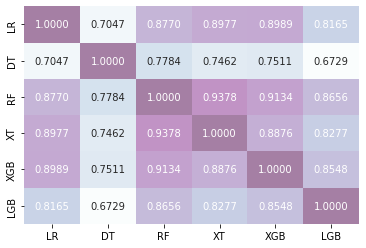

In [27]:
# First, let's capture the predicted probabilities on the validation data set from the models that we liked.
Ens1 = lr_model.predict_proba(X_valid)[:, 1]
Ens2 = dt_model.predict_proba(X_valid)[:, 1]
Ens3 = rf_model.predict_proba(X_valid)[:, 1]
Ens4 = XT_model.predict_proba(X_valid)[:, 1]
Ens5 = XGB_model.predict_proba(X_valid)[:, 1]
Ens6 = LGB_model.predict_proba(X_valid)[:, 1]

EnsDF = pd.DataFrame({'LR' : Ens1, 'DT' : Ens2, 'RF' : Ens3, 'XT' : Ens4, 'XGB' : Ens5, 'LGB' : Ens6})

sns.heatmap(EnsDF.corr(), annot = True, cmap = "BuPu", alpha = 0.5, fmt = ".4f", cbar = False)
plt.plot()

Here are some candidates for ensemble models. Some of them outscore the pure LGBM model on the validation data, even though they contain some components that are less accurate than the LGBM. The combination of LGBM and LR looks promising, as those were our first and third-best models but they have relatively low correlation to each other. In fact, combos heavy on LGBM and LR generally outperform combos of LGBM and XGB - the predictions of LGBM and LGB might just be too similar to each other to make a good ensemble.

We ended up submitting the 80% LGB, 15% LR and 5% RF blended model on the test data and achieved a public score of 78.737%, which does in fact beat the pure light GBM score.

In [35]:
# Candidates for ensemble models:
Scenarios = ('Equal weight', 'Top 5 equal', 'Top 4 equal', 'Top 3 equal', 'Top 2 equal', 'LGB+LR', 'Half LGB half mixed', 
             '70/20/10 blend', '80/15/5 blend', 'Pure LGB')
LR_wt =   (1/6, 1/5, 1/4, 1/3,   0, 1/2,  0.1,  0.1, 0.15,  0)
DT_wt  =  (1/6,   0,   0,   0,   0,   0,  0.1,    0,    0,  0)
RF_wt  =  (1/6, 1/5, 1/4,   0,   0,   0,  0.1,    0, 0.05,  0)
XT_wt  =  (1/6, 1/5,   0,   0,   0,   0,  0.1,  0.2,    0,  0)
XGB_wt  = (1/6, 1/5, 1/4, 1/3, 1/2,   0,  0.1,    0,    0,  0) 
LGB_wt  = (1/6, 1/5, 1/4, 1/3, 1/2, 1/2,  0.5,  0.7,  0.8,  1) 

def Ensemble(a, b, c, d, e, f):
    E = a * Ens1 + b * Ens2 + c * Ens3 + d * Ens4 + e * Ens5 + f * Ens6
    return(np.round(roc_auc_score(y_valid, E),6))

EnsDF_wt = pd.DataFrame({'Scenario' : Scenarios, 'LR' : LR_wt, 'DT' : DT_wt, 'RF' : RF_wt, 'XT' : XT_wt,  'XGB' : XGB_wt, 'LGB' : LGB_wt})
EnsDF_wt['Score'] = EnsDF_wt.apply(lambda row: Ensemble(row['LR'], row['DT'], row['RF'], row['XT'], row['XGB'], row['LGB']),axis = 1)
EnsDF_wt.sort_values('Score', ascending = False)

,Scenario,LR,DT,RF,XT,XGB,LGB,Score
7,70/20/10 blend,0.100000,0.000000,0.000000,0.200000,0.000000,0.700000,0.788142
8,80/15/5 blend,0.150000,0.000000,0.050000,0.000000,0.000000,0.800000,0.788138
4,Top 2 equal,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.788115
9,Pure LGB,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.788100
6,Half LGB half mixed,0.100000,0.100000,0.100000,0.100000,0.100000,0.500000,0.787720
3,Top 3 equal,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.787529
5,LGB+LR,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.787240
2,Top 4 equal,0.250000,0.000000,0.250000,0.000000,0.250000,0.250000,0.786767
1,Top 5 equal,0.200000,0.000000,0.200000,0.200000,0.200000,0.200000,0.786663
0,Equal weight,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.784604


# Visualizing Model Outputs
This section has been moved to another notebook (see link below.) The code cell below this one creates a data frame that gets loaded into Final Model Evaluation Notebook, and the graphics are generated from this dataframe only. The model that I am sending to the Evaluation notebook is the pure Light GBM model.

https://www.kaggle.com/cloycebox/final-model-evaluation-notebook-cjp-and-friends/edit/run/80947983

In [29]:
output_data = pd.DataFrame({'target': y_valid, 'prediction' : LGB_model.predict_proba(X_valid)[:,1]})
output_data['binary'] = np.floor(output_data['prediction'] + 0.5)     # convert probabilistic predictions to 0/1 binary predictions
output_data.head(5)
output_data.to_pickle("./output.pkl", compression='infer', storage_options=None)

# Final Model Selection - save data
We need to save the preprocessor, plus the models that we are going to consider for the ensemble model, to joblib.

In [30]:
gc.collect()

# Logistic Regression
params_01 = {'C' : 0.005, 'penalty' : 'l2'}
final_model_01 = LogisticRegression(**params_01, max_iter = 400, solver = 'lbfgs')
final_model_01.fit(X_train, y_train)
joblib.dump(final_model_01, 'default_model_final_LR.joblib')

# Light GBM
final_model_02 = lgb.LGBMClassifier(**params)
final_model_02.fit(X_train, y_train)
joblib.dump(final_model_02, 'default_model_final_LGB.joblib')

# Random Forest
params_03 = {'max_depth' : 39, 'min_samples_leaf' : 37}
final_model_03 = RandomForestClassifier(**params_03, random_state=1, n_estimators=100)
final_model_03.fit(X_train, y_train)
joblib.dump(final_model_03, 'default_model_final_RF.joblib')

joblib.dump(preprocessor, 'default_preprocessor_final.joblib') 

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1


['default_preprocessor_final.joblib']

# Appendix

### Feature Importance (Light GBM)
AC_ratio (basically the term of the loan) is the most important feature, followed by age, length of time since ID changed, then the credit bureau scores. Creating the right engineered features was the key to a good performing model; the top 50 contains many of the features that we created.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


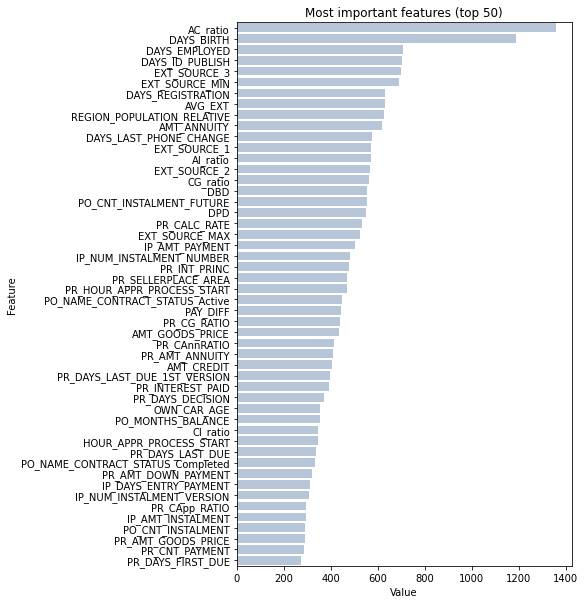

In [31]:
LGB_model.fit(X_train, y_train)
feature_imp = pd.DataFrame(zip(LGB_model.feature_importances_, features), columns=['Value','Feature']).sort_values(by="Value", ascending=False)

plot_data = feature_imp.iloc[0:50,:]
plt.figure(figsize=[6,10])
sns.barplot(plot_data['Value'], plot_data['Feature'], orient = "h", color = "lightsteelblue")
plt.title("Most important features (top 50)")
plt.show()

### Optuna study results for random forest model

In [32]:
import optuna as op
from optuna import create_study
from sklearn import datasets

def objective(trial):
    maxD = trial.suggest_int('max_depth', 30, 40)                            # try integers in the range 30-40
    minSL = trial.suggest_int('min_samples_leaf', 30, 40)
    model = RandomForestClassifier(random_state=1, n_estimators=100, max_depth = maxD, min_samples_leaf = minSL)
    model.fit(X_train[0:20000], y_train[0:20000])                            # for our study, limit the training data to 20,000
    accuracy = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])     # score on roc_auc for the validation data
    return accuracy

study = op.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50, n_jobs = -1)                        # select how many trials we want. Didn't see any improvement after 20 trials
trial = study.best_trial                                                     # ended up being 37 and 30
print("Best Tuning Parameters : {} \n with roc_auc_score of : {:.4f} ".format(trial.params,trial.value))

[I 2021-12-08 04:51:59,110] A new study created in memory with name: no-name-0332b715-20e1-4b31-aef4-ad25635b79e4
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
[I 2021-12-08 04:52:18,373] Trial 1 finished with value: 0.7518899409096093 and parameters: {'max_depth': 39, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.7518899409096093.
[I 2021-12-08 04:52:18,539] Trial 3 finished with value: 0.752645798711815 and parameters: {'max_depth': 40, 'min_samples_leaf': 39}. Best is trial 3 with value: 0.752645798711815.
[I 2021-12-08 04:52:18,692] Trial 2 finished with value: 0.7529461358609848 and parameters: {'max_depth': 36, 'min_samples_leaf': 37}. Best is trial 2 with value: 0.7529461358609848.
[I 2021-12-08 04:52:19,529] Trial 0 finished with value: 0.7524083037908132 and parameters: {'

Best Tuning Parameters : {'max_depth': 31, 'min_samples_leaf': 33} 
 with roc_auc_score of : 0.7533 


### Optuna study results for LGBM

In [33]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna as op
from optuna import create_study
from sklearn import datasets

params = {'boosting_type': 'gbdt', 'objective': 'binary',                           # choices for boosting type are 'gbdt', 'rf', 'dart', 'goss'     
          'n_jobs': -1, 'learning_rate': 0.02,                                      # default learning rate is 0.1 - lower numbers are working well
          'n_estimators' : 1600, 'num_leaves' : 28, 'max_depth' : 18,               # these all seem pretty reasonable
          'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.8,
          'subsample_freq': 1, 'colsample_bytree': 0.8,                             # 'reg_alpha': 20, 'reg_lambda': 20, 
          'min_split_gain': 0.5, 'min_child_weight': 1,
          'min_child_samples': 10, 'scale_pos_weight': 11.5, 'num_class' : 1,       # about 92% target=0 to 8% target=1 - ratio is about 11.5 to 1
          'metric' : 'auc'
          }

def objective(trial):
    l1 = trial.suggest_int('lambda_l1', 0,8)                              # try integers in the range 30-40
    l2 = trial.suggest_int('lambda_l2', 0,8)
    model = LGBMClassifier(**params, random_state=1, lambda_l1 = l1 * 5, lambda_l2 = l2 * 5)
    model.fit(X_train[0:1000], y_train[0:1000])                                              # for our study, limit the training data to 20,000
    accuracy = roc_auc_score(y_valid, model.predict_proba(X_valid)[:,1])     # score on roc_auc for the validation data
    return accuracy

study = op.create_study(direction = "maximize")
study.optimize(objective, n_trials = 20, n_jobs = -1)                        # select how many trials we want. Didn't see any improvement after 20 trials
trial = study.best_trial                                                      # looks like good values are ~28 leaves, ~2400 estimators, max depth ~18
print("Best Tuning Parameters : {} \n with roc_auc_score of : {:.4f} ".format(trial.params,trial.value))


[I 2021-12-08 04:56:06,587] A new study created in memory with name: no-name-57045f54-80cc-4542-85ac-a55ff1e3b4df
/opt/conda/lib/python3.7/site-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2021-12-08 04:56:13,093] Trial 2 finished with value: 0.6786656691133653 and parameters: {'lambda_l1': 7, 'lambda_l2': 1}. Best is trial 2 with value: 0.6786656691133653.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2021-12-08 04:56:16,120] Trial 0 finished with value: 0.6888245295784291 and parameters: {'lambda_l1': 5, 'lambda_l2': 2}. Best is trial 0 with value: 0.6888245295784291.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


[I 2021-12-08 04:56:19,238] Trial 3 finished with value: 0.6906703587186325 and parameters: {'lambda_l1': 4, 'lambda_l2': 5}. Best is trial 3 with value: 0.6906703587186325.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2021-12-08 04:56:20,676] Trial 1 finished with value: 0.6906209185156141 and parameters: {'lambda_l1': 1, 'lambda_l2': 0}. Best is trial 3 with value: 0.6906703587186325.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2021-12-08 04:56:21,737] Trial 4 finished with value: 0.684143378668142 and parameters: {'lambda_l1': 6, 'lambda_l2': 5}. Best is trial 3 with value: 0.6906703587186325.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40


[I 2021-12-08 04:56:28,069] Trial 5 finished with value: 0.6917418298810495 and parameters: {'lambda_l1': 2, 'lambda_l2': 1}. Best is trial 5 with value: 0.6917418298810495.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2021-12-08 04:56:32,702] Trial 6 finished with value: 0.6920175974107889 and parameters: {'lambda_l1': 4, 'lambda_l2': 7}. Best is trial 6 with value: 0.6920175974107889.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25


[I 2021-12-08 04:56:34,430] Trial 7 finished with value: 0.6935153911428693 and parameters: {'lambda_l1': 3, 'lambda_l2': 4}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20


[I 2021-12-08 04:56:41,674] Trial 9 finished with value: 0.6935153911428693 and parameters: {'lambda_l1': 3, 'lambda_l2': 4}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2021-12-08 04:56:42,442] Trial 8 finished with value: 0.6910790885652518 and parameters: {'lambda_l1': 1, 'lambda_l2': 8}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2021-12-08 04:56:44,912] Trial 11 finished with value: 0.6923966366872317 and parameters: {'lambda_l1': 4, 'lambda_l2': 4}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2021-12-08 04:56:49,950] Trial 13 finished with value: 0.6726414314482811 and parameters: {'lambda_l1': 8, 'lambda_l2': 3}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30


[I 2021-12-08 04:56:54,646] Trial 12 finished with value: 0.6920985772895292 and parameters: {'lambda_l1': 4, 'lambda_l2': 6}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2021-12-08 04:56:58,261] Trial 10 finished with value: 0.6875371736335553 and parameters: {'lambda_l1': 0, 'lambda_l2': 5}. Best is trial 7 with value: 0.6935153911428693.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2021-12-08 04:56:59,502] Trial 14 finished with value: 0.6938911585741113 and parameters: {'lambda_l1': 2, 'lambda_l2': 3}. Best is trial 14 with value: 0.6938911585741113.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15


[I 2021-12-08 04:57:05,405] Trial 15 finished with value: 0.6945107480137642 and parameters: {'lambda_l1': 2, 'lambda_l2': 6}. Best is trial 15 with value: 0.6945107480137642.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35


[I 2021-12-08 04:57:09,922] Trial 16 finished with value: 0.6938911585741113 and parameters: {'lambda_l1': 2, 'lambda_l2': 3}. Best is trial 15 with value: 0.6945107480137642.
[I 2021-12-08 04:57:13,842] Trial 18 finished with value: 0.6938911585741113 and parameters: {'lambda_l1': 2, 'lambda_l2': 3}. Best is trial 15 with value: 0.6945107480137642.
[I 2021-12-08 04:57:13,862] Trial 17 finished with value: 0.6938911585741113 and parameters: {'lambda_l1': 2, 'lambda_l2': 3}. Best is trial 15 with value: 0.6945107480137642.
[I 2021-12-08 04:57:15,958] Trial 19 finished with value: 0.6935955068896715 and parameters: {'lambda_l1': 2, 'lambda_l2': 7}. Best is trial 15 with value: 0.6945107480137642.


Best Tuning Parameters : {'lambda_l1': 2, 'lambda_l2': 6} 
 with roc_auc_score of : 0.6945 
